In [1]:
from google.colab import drive
drive.mount('/content/drive')


!unzip drive/My\ Drive/Stratfold2.zip
!unzip drive/My\ Drive/IndependentSet.zip

Streaming output truncated to the last 5000 lines.
  inflating: Independent - TestSet/Epithelioid/TCGA-YS-A95B-01Z-00-DX1.95D754B0-A70F-478E-AE2B-5663A4DD0CF2.svs/34554-15062.jpg  
  inflating: Independent - TestSet/Epithelioid/TCGA-YS-A95B-01Z-00-DX1.95D754B0-A70F-478E-AE2B-5663A4DD0CF2.svs/29238-16834.jpg  
  inflating: Independent - TestSet/Epithelioid/TCGA-YS-A95B-01Z-00-DX1.95D754B0-A70F-478E-AE2B-5663A4DD0CF2.svs/74424-14176.jpg  
  inflating: Independent - TestSet/Epithelioid/TCGA-YS-A95B-01Z-00-DX1.95D754B0-A70F-478E-AE2B-5663A4DD0CF2.svs/23036-24808.jpg  
  inflating: Independent - TestSet/Epithelioid/TCGA-YS-A95B-01Z-00-DX1.95D754B0-A70F-478E-AE2B-5663A4DD0CF2.svs/20378-08860.jpg  
  inflating: Independent - TestSet/Epithelioid/TCGA-YS-A95B-01Z-00-DX1.95D754B0-A70F-478E-AE2B-5663A4DD0CF2.svs/23036-12404.jpg  
  inflating: Independent - TestSet/Epithelioid/TCGA-YS-A95B-01Z-00-DX1.95D754B0-A70F-478E-AE2B-5663A4DD0CF2.svs/14176-23036.jpg  
  inflating: Independent - TestSet/Epit

In [2]:
#related modules 
import keras
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,auc
from sklearn.metrics import average_precision_score
import tensorflow as tf
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
import os
import glob
import pandas as pd
from fnmatch import fnmatch
from keras.applications.vgg19 import preprocess_input

In [3]:
train_path = "Fold2/Train"
val_path = "Fold2/Validation"
test_path ="/content/Independent - TestSet"

batch_size = 32

loss_function ='categorical_crossentropy'
patience = 5
epoch = 50
final_activation ='softmax'
file_pattern = "*.jpg"
folder_pattern = "*TCGA-*"



base_model = keras.applications.VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)

#reading train and validation data
data_generator = ImageDataGenerator(rescale = 1./255,preprocessing_function=  preprocess_input)
#loop and iterating through train images
train_data_generator = data_generator.flow_from_directory(train_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle =True)
#iterating through images of validation set
val_data_generator = data_generator.flow_from_directory(val_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle = True)
#class wight balance

#class wight balance
# classes = train_data_generator.classes
class_weights_list = class_weight.compute_class_weight('balanced',np.unique(train_data_generator.classes),train_data_generator.classes)
weights = dict(zip(np.unique(train_data_generator.classes),class_weights_list))
print("weights ratio to make the dataset balanced: ",weights)

print("class Indices of train generator :",train_data_generator.class_indices)
print("class Indices of validation generator :",val_data_generator.class_indices)

80142336/80134624 [==============================] - 0s 0us/step
Found 85110 images belonging to 2 classes.
Found 18073 images belonging to 2 classes.
weights ratio to make the dataset balanced:  {0: 0.6871134936140668, 1: 1.8360875005393278}
class Indices of train generator : {'Epithelioid': 0, 'Nonepithelioid': 1}
class Indices of validation generator : {'Epithelioid': 0, 'Nonepithelioid': 1}


In [4]:
model_new = base_model.output
model_new = Flatten(name="flatten")(model_new)
model_new = Dense(2, activation="softmax")(model_new)
 

#this function takes the each patch in WSI then predicts the probability score
def pred_each_patch(path,name):
    y = image.load_img(os.path.join(path, name))
    img = image.img_to_array(y)
    y = np.expand_dims(img, axis = 0)
    y = preprocess_input(y)
    y /= 255
    y_pred = model.predict(y)
    return y_pred
        
def avg(predlist):
    average = sum(predlist)/len(predlist)
    return average

def extract_index_one_frmpred(prediction_list):               
    ypred = np.stack(prediction_list)#we are vertically stacking the predictions
    ypred = np.reshape(ypred, [len(prediction_list),2])#reshaping to 100,2 - np array
    for each in ypred:
    #after reshaping the predictions as we wanted, we are taking the index '1' to compute whole slide level AUC-ROC
        val = each[1]
        pred_prob_list.append(val)#appending all the values into a list - to compute average values of single WSI and maximum of single WSI.
        
    return pred_prob_list
    
def plt_history(history): 
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.tight_layout() 
    plt.show()
    return

def y_labels(path):
  if "Epithelioid" in path:
    y_test_labels.append(0.0)
  elif "Nonepithelioid" in path:
    y_test_labels.append(1.0) 
  return

def prediction_scores(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS):
  #AUC - ROC score
  false_pr_avg,true_pr_avg,threshold = roc_curve(y_test_labels,AVG_LIST_PREDICTIONS)
  roc_auc_avg = auc(false_pr_avg,true_pr_avg)
  print("AUC - ROC on Test data average prediction scores:",roc_auc_avg)
  print("-----------------------------------------------------")
  plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()
  
  false_pr_max,true_pr_max,threshold = roc_curve(y_test_labels,MAX_LIST_PREDICTIONS)
  roc_auc_max = auc(false_pr_max,true_pr_max)
  print("AUC - ROC on Test data maximum prediction scores:",roc_auc_max)
  print("-----------------------------------------------------")
  plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()
 

def pre_recall(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS):
  #presicion - recall curve
  precision, recall, threshold = precision_recall_curve(y_test_labels,AVG_LIST_PREDICTIONS)
  print("Presicion - Recall auc on test data average score predictions:",auc(recall,precision))
 
  print("-----------------------------------------------------")
  plt.plot(precision, recall,color='orange',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall,precision)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()

  precision_max, recall_max, threshold = precision_recall_curve(y_test_labels,MAX_LIST_PREDICTIONS)
  print("Presicion - Recall auc on test data maximum score predictions:",auc(recall_max,precision_max))
 
  print("-----------------------------------------------------")
  plt.plot(precision_max, recall_max,color='cyan',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall_max,precision_max)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()

In [5]:
from keras.models import load_model,Model

model = Model(inputs= base_model.input, outputs= model_new)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

Epoch 1/50
2659/2659 [==============================] - 1476s 555ms/step - loss: 0.4794 - auc: 0.8490 - precision: 0.7627 - recall: 0.7627 - val_loss: 0.7331 - val_auc: 0.7091 - val_precision: 0.6545 - val_recall: 0.6545
Epoch 2/50
2659/2659 [==============================] - 1485s 559ms/step - loss: 0.3010 - auc: 0.9441 - precision: 0.8695 - recall: 0.8695 - val_loss: 0.9783 - val_auc: 0.6191 - val_precision: 0.5901 - val_recall: 0.5901
Epoch 3/50
2659/2659 [==============================] - 1485s 559ms/step - loss: 0.2177 - auc: 0.9708 - precision: 0.9102 - recall: 0.9102 - val_loss: 0.8377 - val_auc: 0.7514 - val_precision: 0.6800 - val_recall: 0.6800
Epoch 4/50
2659/2659 [==============================] - ETA: 0s - loss: 0.1676 - auc: 0.9823 - precision: 0.9316 - recall: 0.9316
Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
2659/2659 [==============================] - 1488s 560ms/step - loss: 0.1676 - auc: 0.9823 - precision: 0.9316 - recall: 0.9316

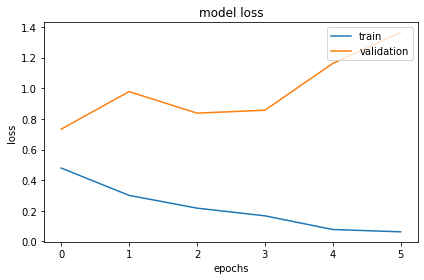

In [6]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor = 0.1,patience=3,verbose = 1)
# early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss',verbose=1, patience=patience)

opt_nadam = tf.keras.optimizers.Nadam(1e-5)#Adam with Nestrov momentum

model.compile(optimizer= opt_nadam, loss=loss_function,metrics = [tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

#Initilaising the model
history = model.fit(train_data_generator, steps_per_epoch=len(train_data_generator.classes)//batch_size, validation_data=val_data_generator,epochs = epoch,class_weight = weights,callbacks =[es,reduce_lr],workers = 4)
    
plt_history(history)#model_loss_plot 

In [7]:
AVG_LIST_PREDICTIONS_VAL = []
MAX_LIST_PREDICTIONS_VAL = []
y_val_labels= []
print("Prediction on validation data using aggregation method")
for path, subdirs, files in os.walk(val_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        if "Epithelioid" in path:
          y_val_labels.append(0.0)
        elif "Nonepithelioid" in path:
          y_val_labels.append(1.0) 

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 36 test set images
        AVG_LIST_PREDICTIONS_VAL.append(avg(predictions))
        MAX_LIST_PREDICTIONS_VAL.append(max(predictions))

Prediction on validation data using aggregation method


AUC - ROC on validation data average prediction scores: 0.8142857142857143
-----------------------------------------------------


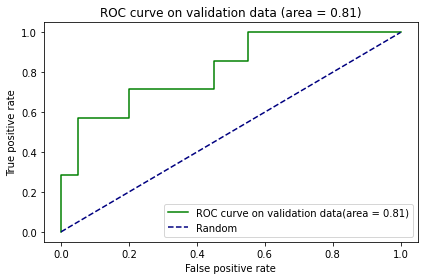

In [8]:
false_pr_avg,true_pr_avg,threshold = roc_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
roc_auc_avg = auc(false_pr_avg,true_pr_avg)
print("AUC - ROC on validation data average prediction scores:",roc_auc_avg)
print("-----------------------------------------------------")
plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

AUC - ROC on validation data maximum prediction scores: 0.6071428571428571
-----------------------------------------------------


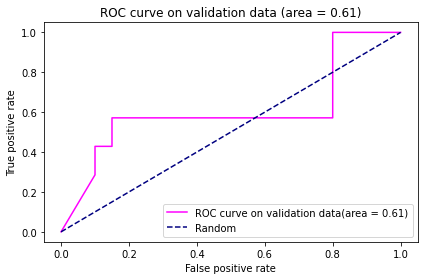

In [9]:
false_pr_max,true_pr_max,threshold = roc_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
roc_auc_max = auc(false_pr_max,true_pr_max)
print("AUC - ROC on validation data maximum prediction scores:",roc_auc_max)
print("-----------------------------------------------------")
plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

Presicion - Recall auc on validation data average score predictions: 0.6800853674803253
-----------------------------------------------------


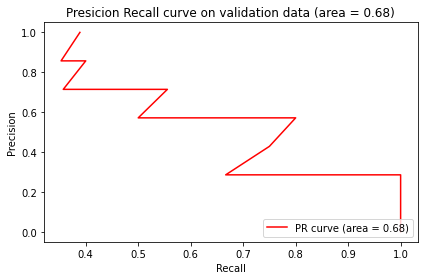

Presicion - Recall auc on validation data maximum score predictions: 0.4783872442257535
-----------------------------------------------------


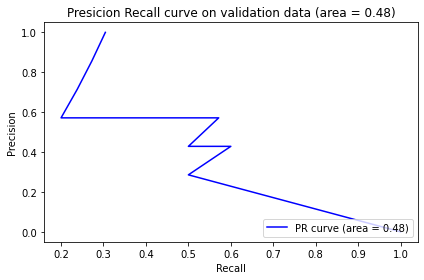

In [10]:
#presicion - recall curve
precision, recall, threshold = precision_recall_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data average score predictions:",auc(recall,precision))
 
print("-----------------------------------------------------")
plt.plot(precision, recall,color='red',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall,precision)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

precision_max, recall_max, threshold = precision_recall_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data maximum score predictions:",auc(recall_max,precision_max))
print("-----------------------------------------------------")
plt.plot(precision_max, recall_max,color='blue',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [11]:
import sklearn
#classification report on average prediction values
AVG_LIST_PREDICTIONS_VAL = [round(x) for x in AVG_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS")
print(sklearn.metrics.classification_report(y_val_labels,AVG_LIST_PREDICTIONS_VAL))

print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")

#classification report on maximum prediction values
MAX_LIST_PREDICTIONS_VAL = [round(x) for x in MAX_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS")
print(sklearn.metrics.classification_report(y_val_labels,MAX_LIST_PREDICTIONS_VAL))

CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85        20
         1.0       0.57      0.57      0.57         7

    accuracy                           0.78        27
   macro avg       0.71      0.71      0.71        27
weighted avg       0.78      0.78      0.78        27

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        20
         1.0       0.26      1.00      0.41         7

    accuracy                           0.26        27
   macro avg       0.13      0.50      0.21        27
weighted avg       0.07      0.26      0.11        27



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
os.remove("/content/Independent - TestSet/Epithelioid/TCGA-UT-A88D-01Z-00-DX2.AE0B6725-767E-4E45-A34D-3BC8F1CBE923.svs/._24836-30158.jpg")
os.remove("/content/Independent - TestSet/Epithelioid/TCGA-UT-A88D-01Z-00-DX2.AE0B6725-767E-4E45-A34D-3BC8F1CBE923.svs/._30158-15079.jpg")
os.remove("/content/Independent - TestSet/Epithelioid/TCGA-UT-A88D-01Z-00-DX2.AE0B6725-767E-4E45-A34D-3BC8F1CBE923.svs/._10644-20401.jpg")
os.remove("/content/Independent - TestSet/Epithelioid/TCGA-UT-A88D-01Z-00-DX2.AE0B6725-767E-4E45-A34D-3BC8F1CBE923.svs/._31045-17740.jpg")
os.remove("/content/Independent - TestSet/Epithelioid/TCGA-UT-A88D-01Z-00-DX2.AE0B6725-767E-4E45-A34D-3BC8F1CBE923.svs/._10644-19514.jpg")
os.remove("/content/Independent - TestSet/Epithelioid/TCGA-UT-A88D-01Z-00-DX2.AE0B6725-767E-4E45-A34D-3BC8F1CBE923.svs/._17740-07983.jpg")
os.remove("/content/Independent - TestSet/Epithelioid/TCGA-UT-A88D-01Z-00-DX2.AE0B6725-767E-4E45-A34D-3BC8F1CBE923.svs/._16853-25723.jpg")

In [15]:
AVG_LIST_PREDICTIONS = []
MAX_LIST_PREDICTIONS = []
y_test_labels= []
print("Prediction on test using aggregation method")
for path, subdirs, files in os.walk(test_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        y_labels(path)

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              # print(os.path.normpath(path))
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 36 test set images
        AVG_LIST_PREDICTIONS.append(avg(predictions))
        MAX_LIST_PREDICTIONS.append(max(predictions))

Prediction on test using aggregation method
Iterating through all the patches in:  TCGA-ZN-A9VQ-01Z-00-DX1.EB537816-420D-4DE6-990D-22A55226FBD5.svs
Iterating through all the patches in:  TCGA-ZN-A9VW-01A-01-TSA.732F2E47-8499-4C7F-B398-8B9A2BB5C826.svs
Iterating through all the patches in:  TCGA-ZN-A9VQ-01A-01-TS1.324684B5-8F18-4AA3-9B32-78382B96760B.svs
Iterating through all the patches in:  TCGA-XT-AASU-01A-01-TS1.EC4D4AC1-01ED-4847-8958-8CDD32992442.svs
Iterating through all the patches in:  TCGA-ZN-A9VV-01A-01-TS1.255B4AB4-2196-4017-B3B9-67191089F45F.svs
Iterating through all the patches in:  TCGA-ZN-A9VV-01Z-00-DX1.EA8BD141-90F1-47C9-B97E-65EEDF7613BE.svs
Iterating through all the patches in:  TCGA-XT-AASU-11A-01-TSA.C37FF230-EA8C-4F8F-AED0-914E482F3DA6.svs
Iterating through all the patches in:  TCGA-XT-AASU-01Z-00-DX1.FC2B9466-98D6-4AF8-89AB-F7409BEF789B.svs
Iterating through all the patches in:  TCGA-ZN-A9VO-01Z-00-DX1.6CE41901-D74E-404F-89D3-7DDB97378854.svs
Iterating through al

AUC - ROC on Test data average prediction scores: 0.49375
-----------------------------------------------------


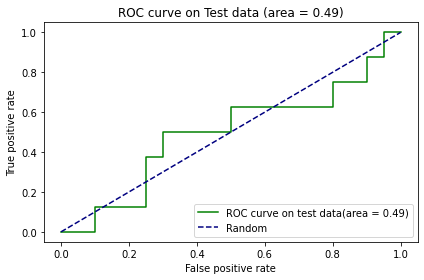

AUC - ROC on Test data maximum prediction scores: 0.6375
-----------------------------------------------------


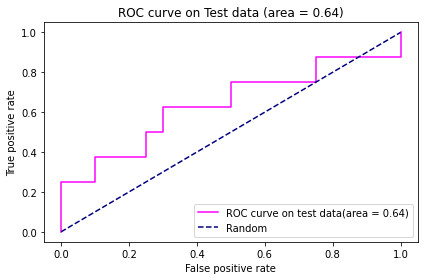

In [16]:
prediction_scores(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS)

Presicion - Recall auc on test data average score predictions: 0.27532244375994375
-----------------------------------------------------


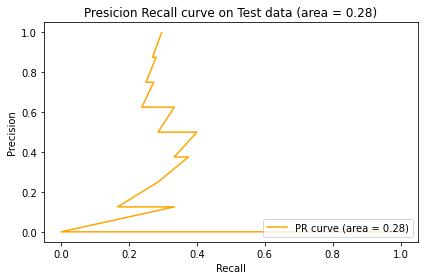

Presicion - Recall auc on test data maximum score predictions: 0.539449555074555
-----------------------------------------------------


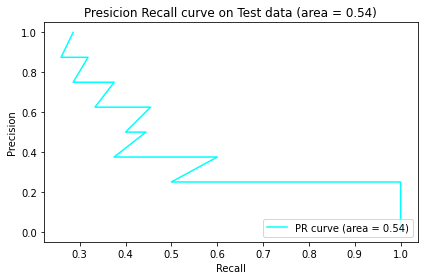

In [17]:
pre_recall(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS)

In [18]:
from sklearn.metrics import classification_report
AVG_LIST_PREDICTIONS = [round(x) for x in AVG_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT")
print(classification_report(y_test_labels,AVG_LIST_PREDICTIONS))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.74      0.70      0.72        20
         1.0       0.33      0.38      0.35         8

    accuracy                           0.61        28
   macro avg       0.54      0.54      0.54        28
weighted avg       0.62      0.61      0.61        28



In [19]:
MAX_LIST_PREDICTIONS = [round(x) for x in MAX_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT for MAX VALUE PREDICTIONS")
print(classification_report(y_test_labels,MAX_LIST_PREDICTIONS))

CLASSIFICATION REPORT for MAX VALUE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        20
         1.0       0.29      1.00      0.44         8

    accuracy                           0.29        28
   macro avg       0.14      0.50      0.22        28
weighted avg       0.08      0.29      0.13        28



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**SAVING THE PREDICTIONS**

In [20]:
#creating a datframe to save predictions with actuals
df = pd.DataFrame()
df['Average'] = AVG_LIST_PREDICTIONS
df['Maximum'] = MAX_LIST_PREDICTIONS
df['Actual labels'] = y_test_labels
#saving into csv file for futher use
df.to_csv('vgg19_test_1000_fold2.csv',index = False,header = True)
!cp vgg19_test_1000_fold2.csv "drive/My Drive/"

In [21]:
#creating a datframe to save predictions with actuals
df_val = pd.DataFrame()
df_val['Average'] = AVG_LIST_PREDICTIONS_VAL
df_val['Maximum'] = MAX_LIST_PREDICTIONS_VAL
df_val['Actual labels'] = y_val_labels
#saving into csv file for futher use
df_val.to_csv('vgg19_1000_val_fold2.csv',index = False,header = True)
!cp vgg19_1000_val_fold2.csv "drive/My Drive/"

In [22]:
model.save("vgg19_1000_fold2.h5")
!cp vgg19_1000_fold2.h5 "drive/My Drive"